In [7]:
from t_graph import TGraph, TEdge, TNode, WeightedGraphFactory
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import unicodedata as ud
# import pymc3 as pm

from measure import measure_performance, PerformanceMeasure


In [8]:
def create_log_grid(max_vertices, min_vertices, num_points_V, num_points_E):
    vertices = np.logspace(np.log10(min_vertices), np.log10(max_vertices), num_points_V, dtype=int)
    edges_completeness = np.linspace(start=0, stop=1, num=num_points_E, endpoint=True)

    assert len(edges_completeness) == num_points_E
    assert len(vertices) == num_points_V

    v_mesh, e_mesh = np.meshgrid(vertices, edges_completeness)
    e_mesh = np.round(e_mesh * v_mesh * (v_mesh - 1) / 2).astype(int)
    v_mesh = v_mesh.flatten()
    e_mesh = e_mesh.flatten()
        
    return v_mesh, e_mesh, edges_completeness


In [9]:
max_vertices = 30
min_vertices = 10
num_points_v = 20
num_points_e = 20

vertices, edges, edges_completeness = create_log_grid(max_vertices, min_vertices, num_points_v, num_points_e)

In [10]:
@measure_performance
def measure_prims_performance(graph: TGraph, root_id: int) -> PerformanceMeasure:
    return graph.prims_mst(root_id)

@measure_performance
def measure_kruskal_performance(graph: TGraph, root_id) -> PerformanceMeasure:
    return graph.kruskal_mst(root_id)

def execute_experiments(graph: TGraph, measure_func: callable, num_experimets=10):
    n_vertices = graph.get_num_vertices()
    root_vertices = np.random.randint(0, n_vertices, num_experimets)
    results = [ measure_func(graph, root)[1].__dict__ for root, _ in zip(root_vertices, range(num_experimets)) ]
    
    return results

In [11]:
graph_factory = WeightedGraphFactory(vertices, edges, 100, 0)

In [45]:
def create_edges_completeness_colum(df):
    df['edges_completeness'] = df[['input_V', "input_E"]].apply(lambda x: x["input_E"] / (x["input_V"] * (x["input_V"] - 1) / 2), axis=1)
    return df

In [56]:
kruskal_data = []
prim_data = []
for g in tqdm(graph_factory):
    kruskal_data.extend(execute_experiments(g, measure_kruskal_performance))
    prim_data.extend(execute_experiments(g, measure_prims_performance))
    
kruskal_df = pd.DataFrame.from_records(kruskal_data)
kruskal_df = create_edges_completeness_colum(kruskal_df)
prim_df = pd.DataFrame.from_records(prim_data)
prim_df = create_edges_completeness_colum(prim_df)


# kruskal_df = pd.read_csv('./outputs/kruskal.csv')
# prim_df = pd.read_csv('./outputs/prim.csv')
# kruskal_df.describe()

400it [00:05, 71.29it/s] 


In [57]:
# kruskal_df.to_csv('./outputs/kruskal.csv')
# prim_df.to_csv('./outputs/prim.csv')

In [58]:
def calc_monomials(x):
    E = x["input_E"]
    V = x["input_V"]
    log_E = np.log10(E) if E > 0 else np.NaN
    log_V = np.log10(V) if V > 0 else np.NaN
    Elog_E = x["input_E"] * log_E
    Elog_V = x["input_E"] * log_V
    return pd.Series({
        "E": E,
        "V": V,
        "log_E": log_E,
        "log_V": log_V,
        "Elog_E": Elog_E,
        "Elog_V": Elog_V
    })

# Prepare the input and output data
kruskal_X = kruskal_df[["input_E", "input_V"]].apply(calc_monomials, axis=1, result_type='reduce')
kruskal_df = pd.concat([kruskal_X, kruskal_df], axis=1)
prim_X = prim_df[["input_E", "input_V"]].apply(calc_monomials, axis=1, result_type='reduce')
prim_df = pd.concat([prim_X, prim_df], axis=1)

In [59]:
def plot_growth(df, algorithm):
    plt.figure(figsize=(12, 10))  # Set the figure size

    plt.suptitle(f'Experimento de {algorithm}', fontsize=16)  # Set the main title

    plt.subplot(221)
    sns.lineplot(data=df, x='input_E', y='elapsed_time', markers=True, dashes=False)
    plt.ylabel('Elapsed Time (ms)', fontsize=12)
    plt.xlabel('|E|', fontsize=12)
    plt.grid(True)

    plt.subplot(222)
    sns.scatterplot(data=df, x='edges_completeness', y='elapsed_time')
    plt.ylabel('Elapsed Time (ms)', fontsize=12)
    plt.xlabel('|E|/max E(|V|)', fontsize=12)
    plt.grid(True)

    plt.subplot(223)
    sns.lineplot(data=df, x='input_V', y='elapsed_time', markers=True, dashes=False)
    plt.ylabel('Elapsed Time (ms)', fontsize=12)
    plt.xlabel('|V|', fontsize=12)
    plt.grid(True)

    plt.subplot(224)
    sns.lineplot(data=df, x='Elog_V', y='elapsed_time', markers=True, dashes=False)
    plt.ylabel('Elapsed Time (ms)', fontsize=12)
    plt.xlabel('|E|log|V|', fontsize=12)
    plt.grid(True)

    # Show the grid lines for all subplots
    plt.grid(True)

    # Show the plot
    plt.show()


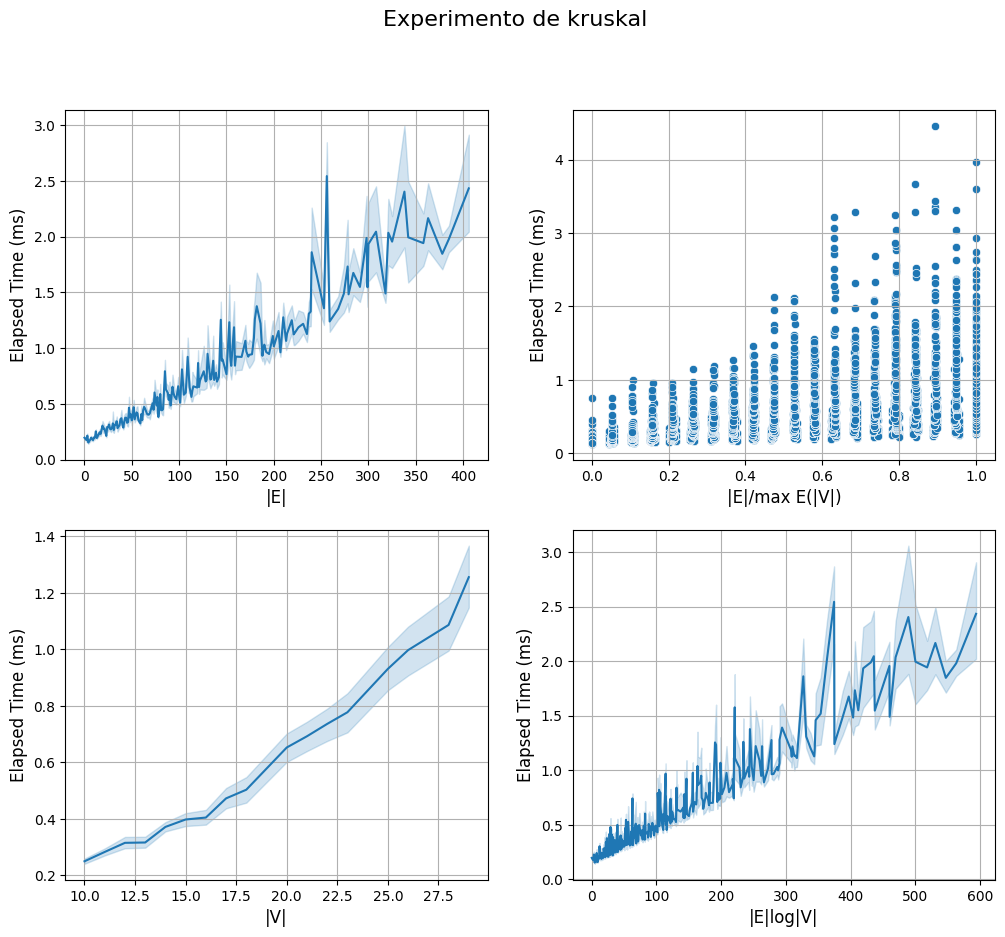

In [60]:
plot_growth(kruskal_df, 'kruskal')

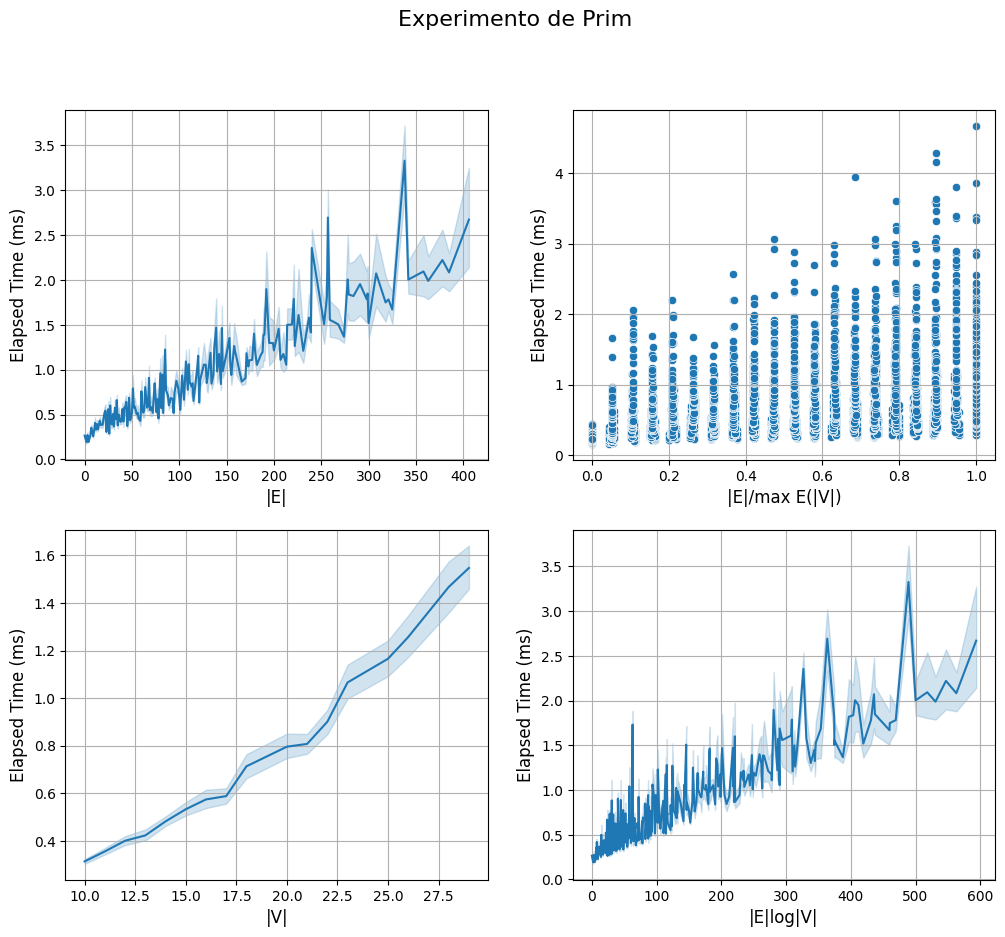

In [61]:
plot_growth(prim_df, 'Prim')

In [65]:
kruskal_df.input_V.values.shape

(4000,)

In [88]:
def get_linear_model(df):

    x = df.Elog_V.values.reshape(-1,1)
    y = df.elapsed_time.values.reshape(-1,1)

    # Create a linear regression model
    model = LinearRegression()
    # Fit the model to the data
    model.fit(x, y)

    # Get the coefficients and intercept
    coefficients = model.coef_
    intercept = model.intercept_
    R2 = model.score(x, y)

    print(f"T(|E|, |V|) = {intercept} + {coefficients[0]} x |E|log|V|")
    print(f"Coeficiente de deteriminação para os dados foi (R²) = {R2:.4f}")
    
    return model


In [89]:
kruskal_lm = get_linear_model(kruskal_df)
prim_lm = get_linear_model(prim_df)

T(|E|, |V|) = [0.1718942] + [0.00359801] x |E|log|V|
Coeficiente de deteriminação para os dados foi (R²) = 0.7783
T(|E|, |V|) = [0.31379781] + [0.00375527] x |E|log|V|
Coeficiente de deteriminação para os dados foi (R²) = 0.6938


In [135]:
import matplotlib.pyplot as plt

def plot_residues(df, model,algorithm):
    x = df.Elog_V.values.reshape(-1,1)
    y = df.elapsed_time.values.reshape(-1,1)
    
    # Generate model predictions
    predictions = model.predict(x)

    # Calculate prediction residues
    residues = (y - predictions)

    print(residues.shape)
    

    # Plot model predictions
    plt.figure(figsize=(12, 6))

    plt.suptitle(f'Experimento de {algorithm}', fontsize=16)  # Set the main title

    # Plot actual vs predicted values
    plt.subplot(121)
    sns.scatterplot(x=x.flatten(), y=y.flatten(), color='blue', label='Actual')
    sns.lineplot(x=x.flatten(), y=predictions.flatten(), color='red', label='Predicted')
    plt.xlabel('|E|log|V|')
    plt.ylabel('Elapsed Time (ms)')
    plt.title('Model Predictions')
    plt.grid(True)
    plt.legend()

    # Plot prediction residues
    plt.subplot(122)
    sns.scatterplot(x=predictions.flatten(), y=residues.flatten(), color='green')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residues')
    plt.grid(True)
    plt.title('Prediction Residues')

    # Show the plots
    plt.tight_layout()
    plt.show()

(4000, 1)


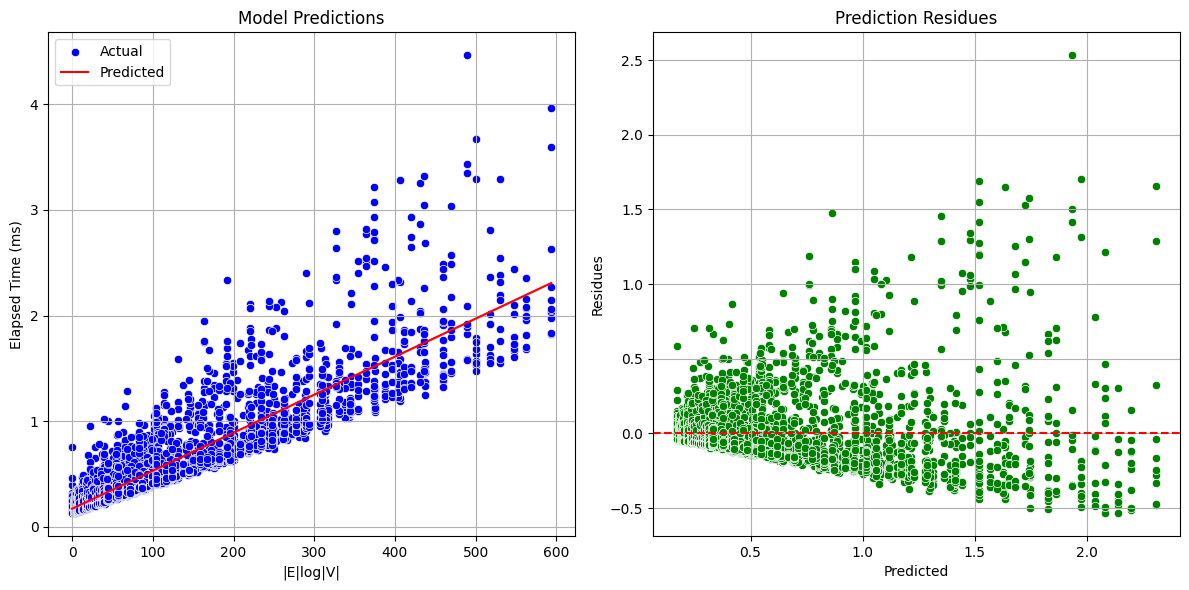

In [136]:
plot_residues(kruskal_df, kruskal_lm)

(4000, 1)


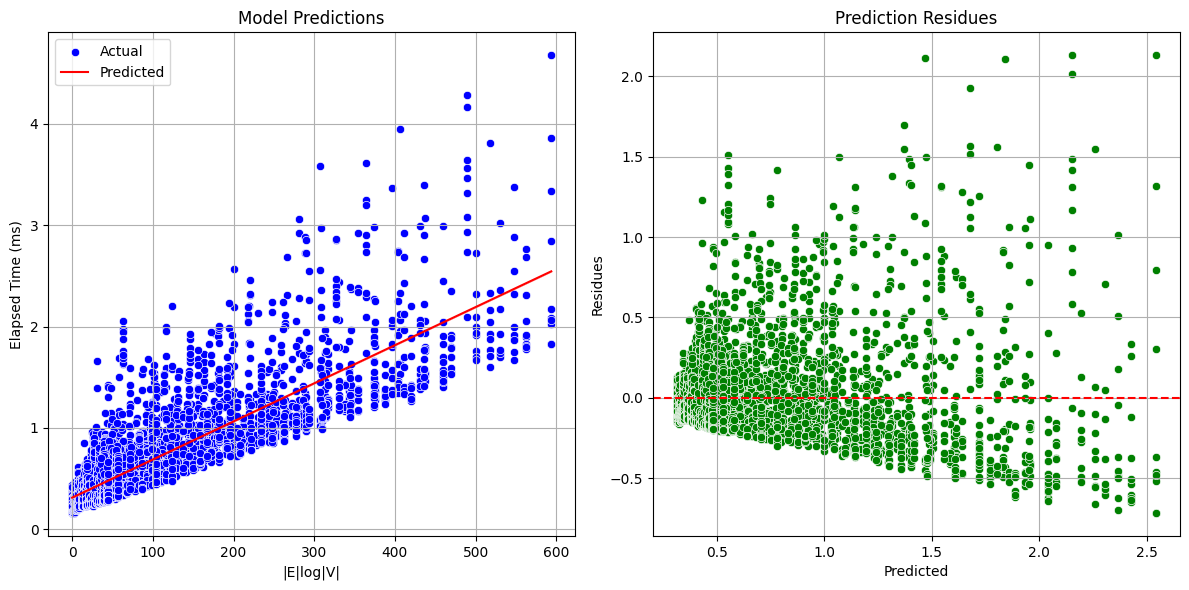

In [137]:
plot_residues(prim_df, prim_lm)